In [1]:
import pandas as pd
from src.setup import get_base
from src.feature_engineering import engineer_features
from src.clustering_utils import silhouette_analysis, elbow_method, build_cluster_pipeline, plot_pca_clusters
from src.features import build_features

In [2]:
df = get_base()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49104 entries, 0 to 49103
Data columns (total 41 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   session_id                      49104 non-null  object        
 1   user_id                         49104 non-null  int64         
 2   trip_id                         16595 non-null  object        
 3   session_start                   49104 non-null  datetime64[ns]
 4   session_end                     49104 non-null  datetime64[ns]
 5   flight_discount                 49104 non-null  bool          
 6   hotel_discount                  49104 non-null  bool          
 7   flight_discount_amount          8266 non-null   float64       
 8   hotel_discount_amount           6188 non-null   float64       
 9   flight_booked                   49104 non-null  bool          
 10  hotel_booked                    49104 non-null  bool          
 11  pa

In [3]:

df_features = build_features(df)

display(df_features.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5998 entries, 0 to 5997
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   user_id                     5998 non-null   int64  
 1   num_trips                   5998 non-null   int64  
 2   num_flights                 5998 non-null   int64  
 3   num_hotels                  5998 non-null   int64  
 4   cancellation_rate           5998 non-null   float64
 5   avg_trip_duration_days      4922 non-null   float64
 6   multi_booking_rate          5537 non-null   float64
 7   total_flight_spend          5998 non-null   float64
 8   total_hotel_spend           5998 non-null   float64
 9   avg_spend_per_trip          5537 non-null   float64
 10  hotel_vs_flight_ratio       5998 non-null   float64
 11  num_sessions                5998 non-null   int64  
 12  avg_session_duration        5998 non-null   float64
 13  avg_clicks_per_session      5998 

None

In [4]:
from src.clustering_pipeline import run_full_pipeline

res = run_full_pipeline(
    df,
    output_dir="output/clustering",
    clustering_methods=["kmeans","gmm","agg","dbscan"],
    n_clusters=4,
    dbscan_eps=0.5
)

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

features = pd.read_csv("output/clustering/user_features_raw.csv")
labels_kmeans = pd.read_csv("output/clustering/labels_kmeans.csv")
metrics = pd.read_csv("output/clustering/clustering_metrics.csv")
pca = pd.read_csv("output/clustering/pca_projection.csv")

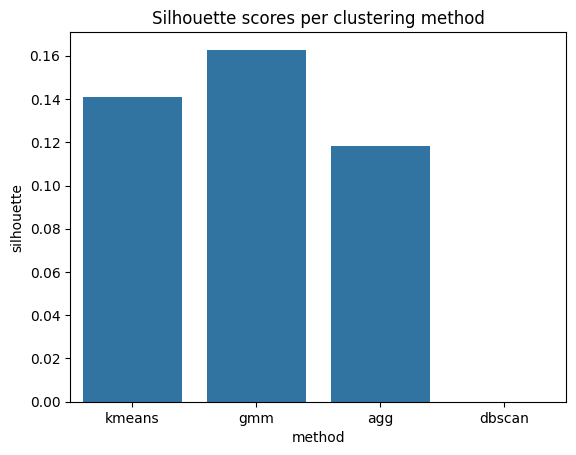

In [6]:
sns.barplot(data=metrics, x="method", y="silhouette")
plt.title("Silhouette scores per clustering method")
plt.show()

In [7]:
cluster_profiles = features.join(labels_kmeans["cluster"]).groupby("cluster").mean()
display(cluster_profiles)

KeyError: 'cluster'

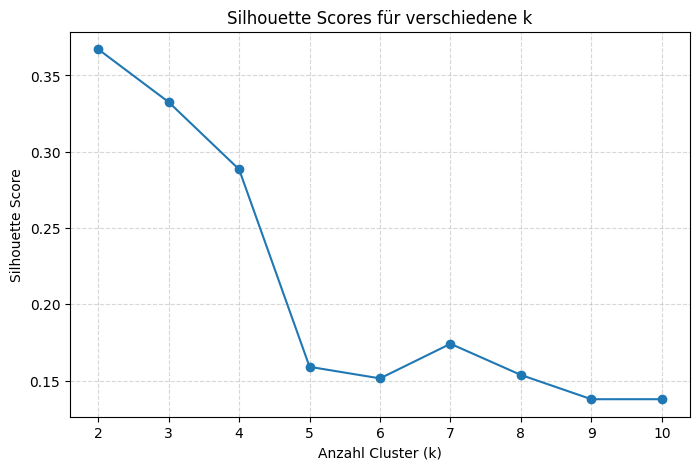

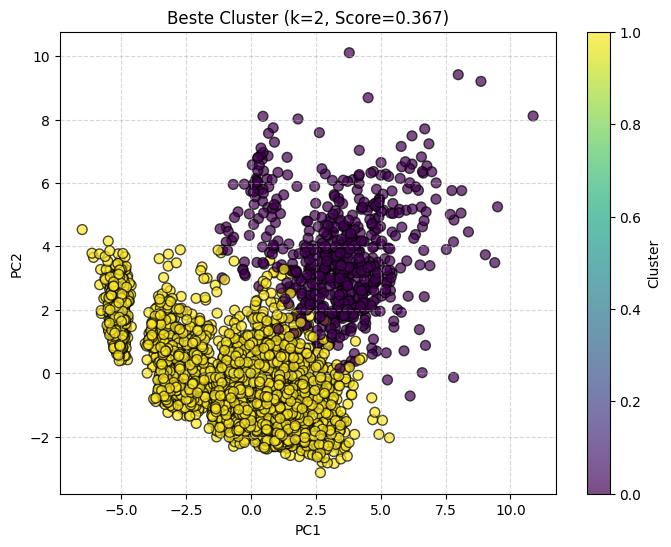

Beste Clusterzahl (Silhouette): 2 mit Score: 0.36722167705721837


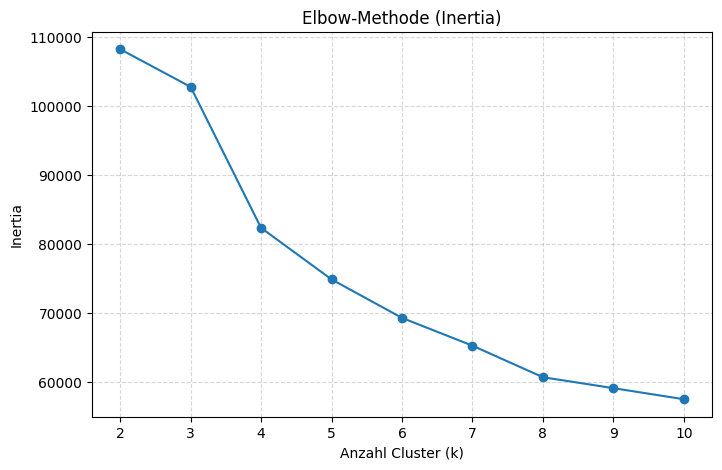

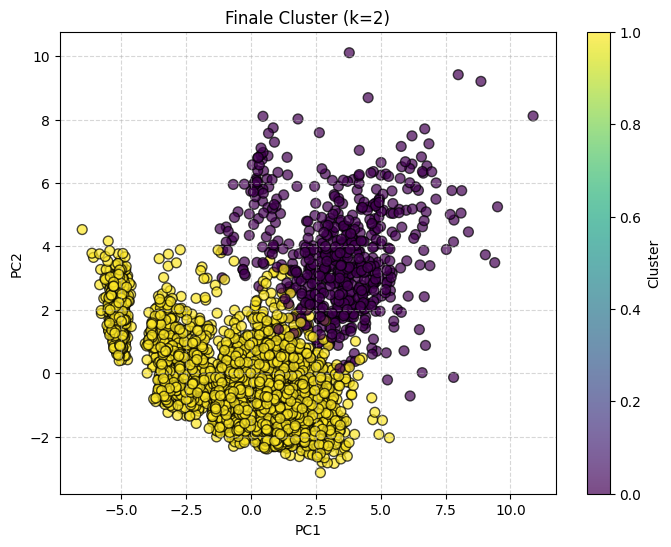

In [ ]:


# Nur numerische Spalten fürs Clustering
X = df_features.select_dtypes(include=["float64", "int64"]).fillna(0)

# ------------------------------
# Silhouette-Analyse
# ------------------------------
best_k, best_score, silhouette_scores = silhouette_analysis(X, k_range=range(2, 11))

print("Beste Clusterzahl (Silhouette):", best_k, "mit Score:", best_score)

# ------------------------------
# Elbow-Methode
# ------------------------------
inertias = elbow_method(X, k_range=range(2, 11))

# ------------------------------
# Finales Clustering mit best_k
# ------------------------------
pipeline = build_cluster_pipeline(n_clusters=best_k)
pipeline.fit(X)

labels = pipeline["kmeans"].labels_
pca_data = pipeline["pca"].transform(pipeline["scaler"].transform(X))

# Cluster Plot
plot_pca_clusters(pca_data, labels, title=f"Finale Cluster (k={best_k})")

PCA: 8 Komponenten erklären 95.77% der Varianz.


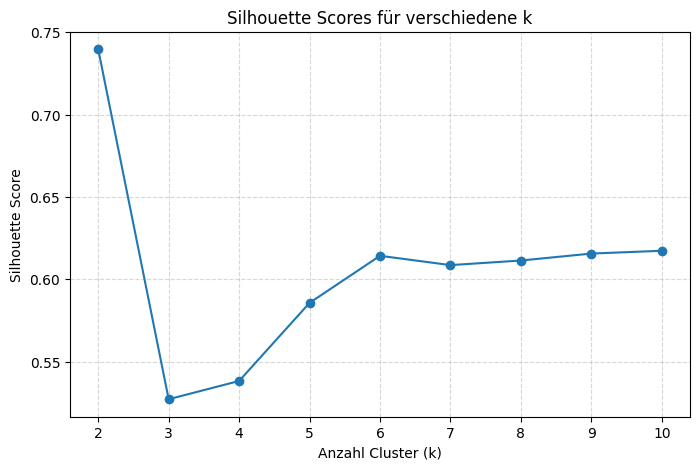

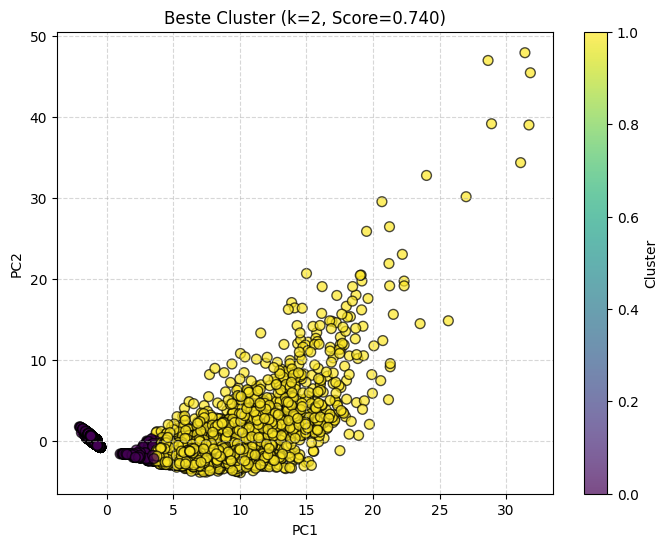

Beste Clusterzahl (Silhouette): 2 mit Score: 0.7396417807065004


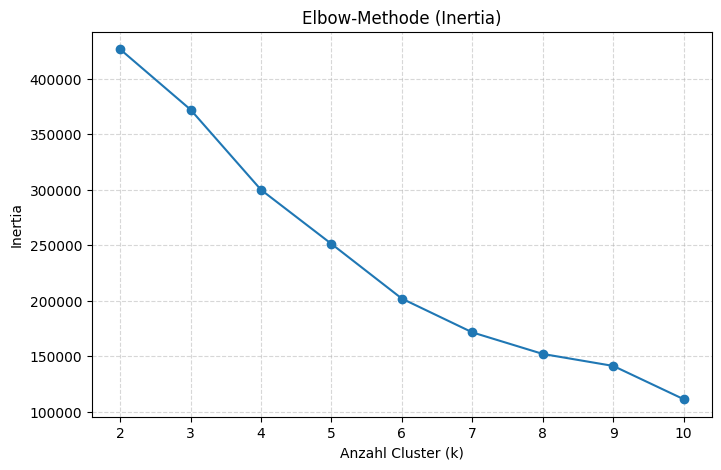

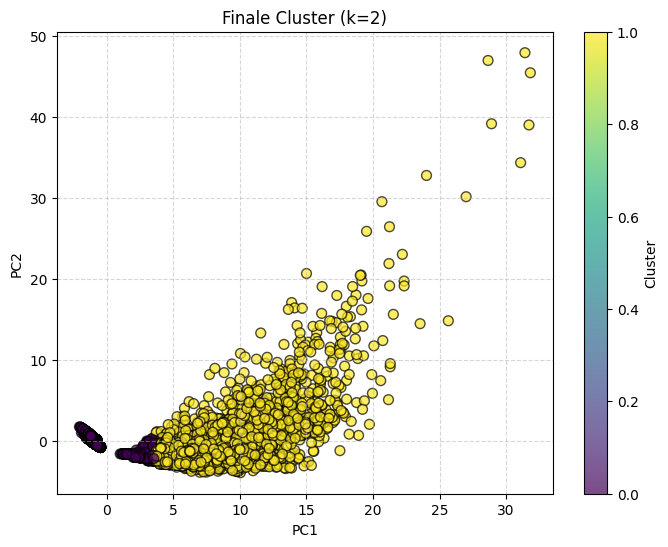

✅ Clusterreport gespeichert: cluster_report.csv
✅ Scores gespeichert: cluster_scores.csv


In [ ]:
import pandas as pd
from src.feature_engineering import engineer_features
from src.clustering_utils import silhouette_analysis, elbow_method, build_cluster_pipeline, plot_pca_clusters, export_cluster_report, choose_pca_components

# ------------------------------
# Daten laden & Feature Engineering
# ------------------------------
df = get_base()
df_features = engineer_features(df)

# Nur numerische Spalten fürs Clustering
X = df_features.select_dtypes(include=["float64", "int64"]).fillna(0)

# ------------------------------
# PCA-Komponenten automatisch wählen (95% Varianz)
# ------------------------------
n_components = choose_pca_components(X, variance_threshold=0.95)

# ------------------------------
# Silhouette-Analyse
# ------------------------------
best_k, best_score, silhouette_scores = silhouette_analysis(X, k_range=range(2, 11), n_components=n_components)

print("Beste Clusterzahl (Silhouette):", best_k, "mit Score:", best_score)

# ------------------------------
# Elbow-Methode
# ------------------------------
inertias = elbow_method(X, k_range=range(2, 11), n_components=n_components)

# ------------------------------
# Finales Clustering mit best_k
# ------------------------------
pipeline = build_cluster_pipeline(n_clusters=best_k, n_components=n_components)
pipeline.fit(X)

labels = pipeline["kmeans"].labels_
pca_data = pipeline["pca"].transform(pipeline["scaler"].transform(X))

# Cluster Plot
plot_pca_clusters(pca_data, labels, title=f"Finale Cluster (k={best_k})")

# ------------------------------
# Export Report
# ------------------------------
export_cluster_report(X, labels, pca_data, silhouette_scores, inertias)

In [ ]:
pd.DataFrame(pca_data)

,0,1,2,3,4,5,6,7
0,-1.179997,0.647847,1.065371,0.087288,0.027677,0.400812,0.011105,-0.114961
1,-1.187144,0.659133,0.984737,0.244637,-0.095830,0.422525,0.011691,-0.121166
2,-1.188195,0.660793,0.972879,0.267776,-0.113993,0.425718,0.011777,-0.122078
3,-1.185935,0.657225,0.998374,0.218026,-0.074943,0.418853,0.011592,-0.120116
4,-1.181626,0.650420,1.046992,0.123154,-0.000475,0.405761,0.011239,-0.116375
...,...,...,...,...,...,...,...,...
55096,6.213939,-1.207075,-0.597279,-1.792341,-1.429333,2.824780,0.717778,0.875145
55097,12.739826,7.015537,-1.442855,-0.506478,0.154817,-1.879696,2.220808,3.556234
55098,7.075574,-2.569918,0.509793,-0.083462,-0.321588,1.447598,4.731441,-0.517270
55099,6.251663,-1.228605,0.267987,0.455837,0.361144,-1.012878,1.518380,-2.213928
